In [5]:
import numpy as np 
import pandas as pd
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt
import glob

from pprint import pprint

In [7]:
df = pd.read_csv('car_train.csv')
test_df = pd.read_csv('car_test.csv')

In [6]:
train_path = 'data/train/'
test_path = 'data/test/'

train_image_path = 'cars_train/'
test_image_path = 'cars_test/'

img_width, img_height = 224, 224

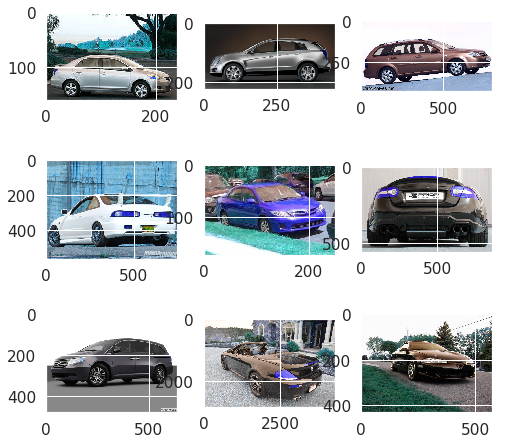

In [49]:
# Lets take a look at some of the images 
columns = 3
rows = 3
fig=plt.figure(figsize=(8, 8))

for index, path in enumerate(glob.glob('cars_train/*.jpg')):
    if index == 9:
        break
    
    img = cv2.imread(path)
    fig.add_subplot(rows, columns, index + 1)
    plt.imshow(img)

In [50]:
# Lets look at all the classes
print('Total number of classes:', len(df['class'].unique()))
pprint(df['class'].unique())

Total number of classes: 196
array(['Audi TTS Coupe 2012', 'Acura TL Sedan 2012',
       'Dodge Dakota Club Cab 2007', 'Hyundai Sonata Hybrid Sedan 2012',
       'Ford F-450 Super Duty Crew Cab 2012',
       'Geo Metro Convertible 1993', 'Dodge Journey SUV 2012',
       'Dodge Charger Sedan 2012', 'Mitsubishi Lancer Sedan 2012',
       'Chevrolet Traverse SUV 2012', 'Buick Verano Sedan 2012',
       'Toyota Sequoia SUV 2012', 'Hyundai Elantra Sedan 2007',
       'Dodge Caravan Minivan 1997', 'Volvo C30 Hatchback 2012',
       'Plymouth Neon Coupe 1999', 'Chevrolet Malibu Sedan 2007',
       'Volkswagen Beetle Hatchback 2012',
       'Chevrolet Corvette Ron Fellows Edition Z06 2007',
       'Chrysler 300 SRT-8 2010', 'BMW M6 Convertible 2010',
       'GMC Yukon Hybrid SUV 2012', 'Nissan Juke Hatchback 2012',
       'Volvo 240 Sedan 1993', 'Suzuki SX4 Sedan 2012',
       'Dodge Ram Pickup 3500 Crew Cab 2010', 'Spyker C8 Coupe 2009',
       'Land Rover Range Rover SUV 2012',
       'Hyund

# Preprocessing

In [ ]:
# Create folders for all class
for c in df['class'].unique():
    if not os.path.exists(train_path + c):
        os.mkdir(train_path + c.replace('/', '\\'))
        os.mkdir(test_path + c.replace('/', '\\'))

In [ ]:
# Split dataframe to train test 8:2 ratio
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

In [ ]:
for index, row in train.iterrows():
    if os.path.exists(train_image_path + row['fname']):
        if not os.path.exists(train_path + row['fname']):
            src_img = cv2.imread(train_image_path + row['fname'])
            (x1, y1, x2, y2) = row['bbox_x1'], row['bbox_y1'], row['bbox_x2'], row['bbox_y2']
            height, width = src_img.shape[:2]
            
            # margins of 16 pixels
            margin = 16
            x1 = max(0, x1 - margin)
            y1 = max(0, y1 - margin)
            x2 = min(x2 + margin, width)
            y2 = min(y2 + margin, height)
    
            crop_image = src_img[y1:y2, x1:x2]
    
            dst_img = cv2.resize(crop_image, (img_height, img_width))
            dst_path = train_path + row['class'] + '/' + row['fname']
            
            cv2.imwrite(dst_path, dst_img)

for index, row in test.iterrows():
    if os.path.exists(train_image_path + row['fname']):
        if not os.path.exists(test_path + row['fname']):
            src_img = cv2.imread(train_image_path + row['fname'])
            (x1, y1, x2, y2) = row['bbox_x1'], row['bbox_y1'], row['bbox_x2'], row['bbox_y2']
            height, width = src_img.shape[:2]
            
            # margins of 16 pixels
            margin = 16
            x1 = max(0, x1 - margin)
            y1 = max(0, y1 - margin)
            x2 = min(x2 + margin, width)
            y2 = min(y2 + margin, height)
    
            crop_image = src_img[y1:y2, x1:x2]
    
            dst_img = cv2.resize(crop_image, (img_height, img_width))
            dst_path = test_path + row['class'] + '/' + row['fname']
            
            cv2.imwrite(dst_path, dst_img)

# Build model

In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import densenet
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout
from keras.layers import Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import Model

Using TensorFlow backend.


In [3]:
img_width, img_height = 224, 224
nb_train_samples = 8144
nb_validation_samples = 8041
epochs = 10
batch_size = 32
n_classes = 196

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    #shear_range=0.2,
    zoom_range=0.2,
    #fill_mode = 'constant',
    #cval = 1,
    rotation_range = 5,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')


validation_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 6488 images belonging to 196 classes.
Found 1615 images belonging to 196 classes.


In [2]:
def build_model():
    base_model = densenet.DenseNet121(
        input_shape=(img_width, img_height, 3),
#         weights='../input/full-keras-pretrained-no-top/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False,
        pooling='avg'
    )
    
    for layer in base_model.layers:
        layer.trainable = True
    
    x = base_model.output
    x = Dense(1000, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    x = Dense(500, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [18]:
model = build_model()
model.compile(
    loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mse']
)

In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [29]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1)
callbacks_list = [early_stop, reduce_lr]

In [32]:
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=callbacks_list
)
model.save_weights('models/densenet.h5')

Epoch 1/10
203/203 [==============================] - 119s 586ms/step - loss: 5.4449 - acc: 0.0077 - mean_squared_error: 0.0051 - val_loss: 5.4583 - val_acc: 0.0112 - val_mean_squared_error: 0.0051
Epoch 2/10
203/203 [==============================] - 111s 549ms/step - loss: 5.4453 - acc: 0.0077 - mean_squared_error: 0.0051 - val_loss: 5.4592 - val_acc: 0.0113 - val_mean_squared_error: 0.0051
Epoch 3/10
203/203 [==============================] - 117s 574ms/step - loss: 5.4457 - acc: 0.0077 - mean_squared_error: 0.0051 - val_loss: 5.4576 - val_acc: 0.0113 - val_mean_squared_error: 0.0051
Epoch 4/10
203/203 [==============================] - 112s 551ms/step - loss: 5.4459 - acc: 0.0077 - mean_squared_error: 0.0051 - val_loss: 5.4602 - val_acc: 0.0113 - val_mean_squared_error: 0.0051
Epoch 5/10
203/203 [==============================] - 110s 544ms/step - loss: 5.4461 - acc: 0.0077 - mean_squared_error: 0.0051 - val_loss: 5.4597 - val_acc: 0.0112 - val_mean_squared_error: 0.0051
Epoch 6/10

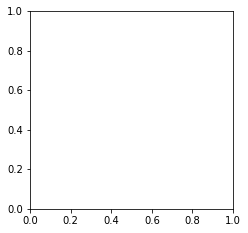

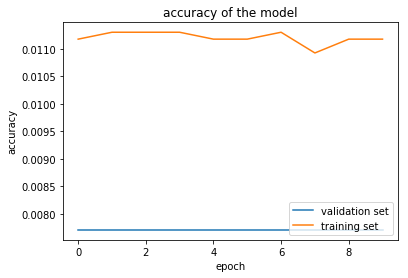

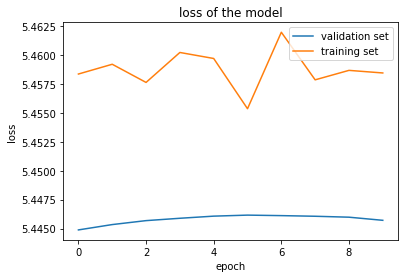

In [35]:
fig=plt.figure(figsize=(8, 8))
fig.add_subplot(2, 2, 2)

# accuracy 
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('accuracy of the model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation set','training set'], loc='lower right')
plt.savefig('models/' + 'densenet' + '_acc.png')

# loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss of the model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation set','training set'], loc='upper right')
plt.savefig('models/' + 'densenet' + '_loss.png')

plt.show()

# Test model accuracy

In [39]:
model.evaluate_generator(validation_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False)

[763.345121269108, 0.006811145543129451, 0.005089365706805013]

In [42]:
pred = model.predict_generator(validation_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)
predicted = np.argmax(pred, axis=1)

51/51 [==============================] - 10s 203ms/step


In [46]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn

Confusion Matrix


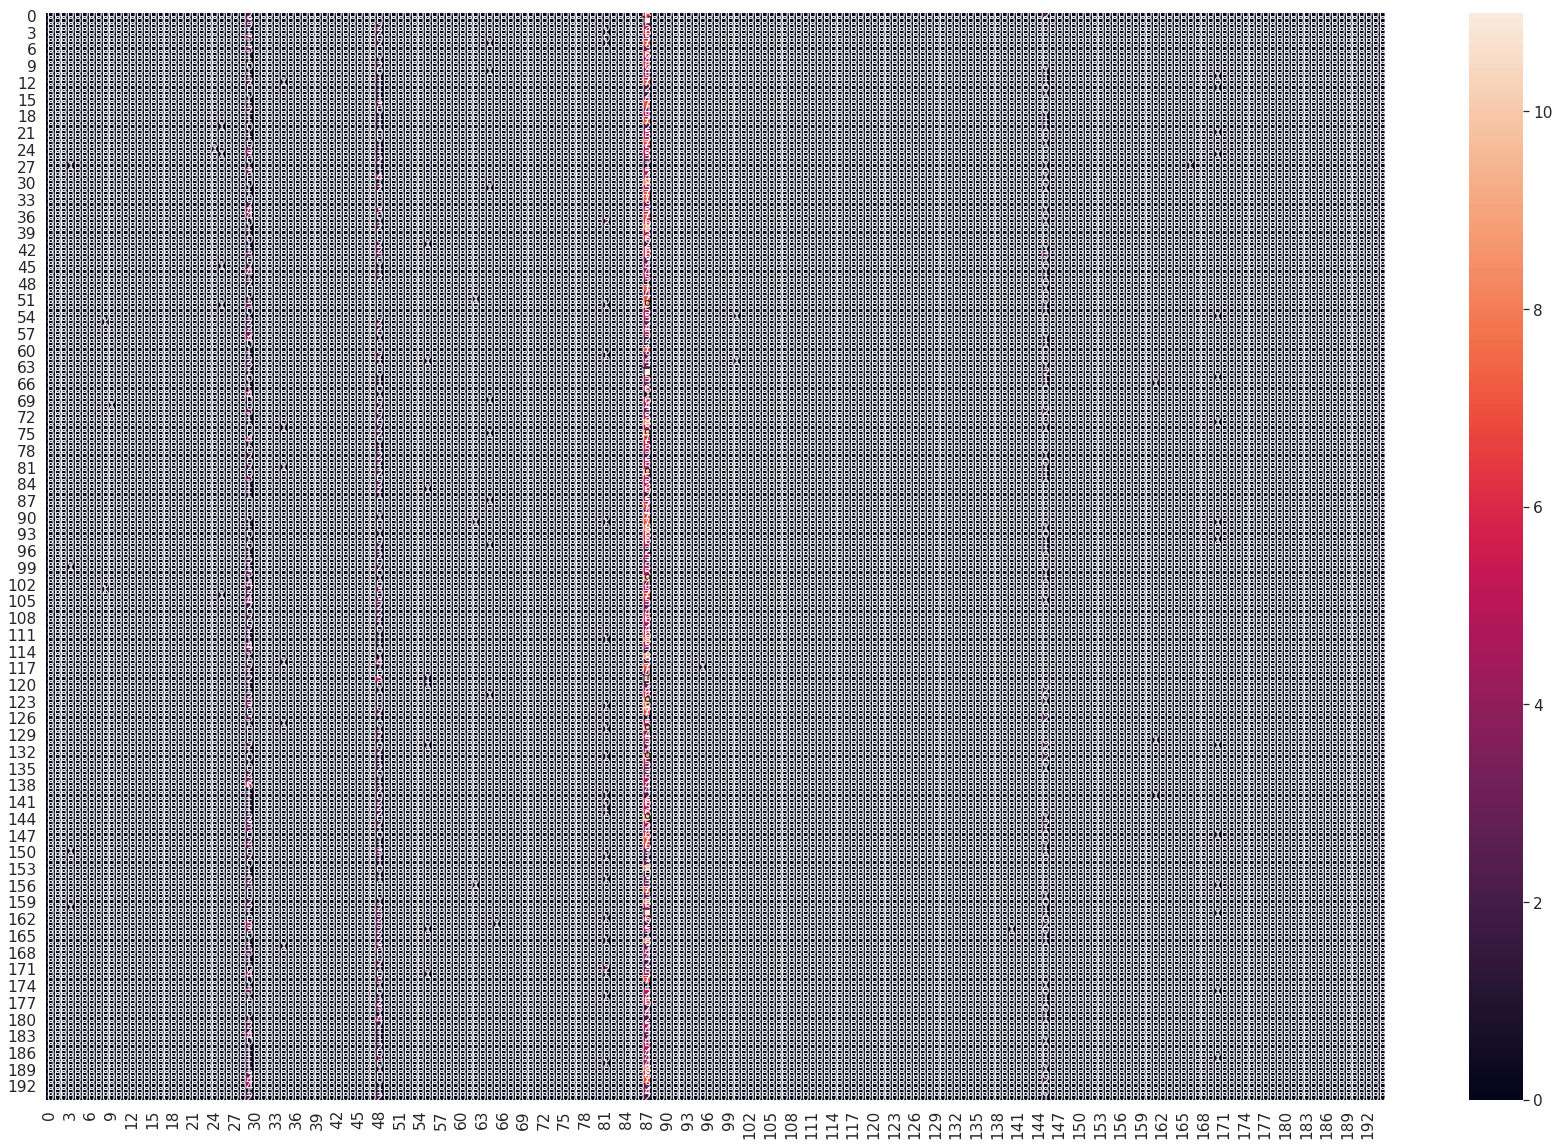


Classification Report
                                                        precision    recall  f1-score   support

                                   Audi TTS Coupe 2012       0.00      0.00      0.00        10
                                   Acura TL Sedan 2012       0.00      0.00      0.00        14
                            Dodge Dakota Club Cab 2007       0.00      0.00      0.00         9
                      Hyundai Sonata Hybrid Sedan 2012       0.00      0.00      0.00        10
                   Ford F-450 Super Duty Crew Cab 2012       0.00      0.00      0.00         8
                            Geo Metro Convertible 1993       0.00      0.00      0.00        12
                                Dodge Journey SUV 2012       0.00      0.00      0.00         6
                              Dodge Charger Sedan 2012       0.00      0.00      0.00         7
                          Mitsubishi Lancer Sedan 2012       0.00      0.00      0.00         6
                

/home/superceed1/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/superceed1/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/superceed1/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/superceed1/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', ave

In [57]:
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, np.argmax(pred, axis=1))
plt.figure(figsize = (30,20))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()
print()
print('Classification Report')
print(classification_report(validation_generator.classes, predicted, target_names=df['class'].unique(), labels=range(len(df['class'].unique()))))

# Predict single

In [44]:
model.load_weights('models/densenet.h5')

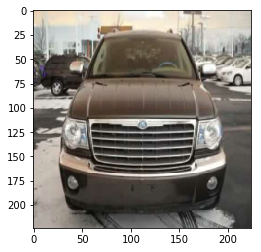

In [46]:
img = cv2.imread('cars_test/00071.jpg')
img = cv2.resize(img, (img_height, img_width))
plt.imshow(img)
img = np.expand_dims(img, axis=0)

In [47]:
class_pos = np.argmax(model.predict(img))
df['class'][class_pos]

'Mercedes-Benz 300-Class Convertible 1993'